In [ ]:
# INITIAL SETUP
# - create a new Folder named "scraping_folder"
# - download the file from the following link and upload it within the folder
# https://drive.google.com/file/d/1WREPAe9p9ntJ5TdW-0qkLco8qymdzzh3/view?usp=sharing

In [ ]:
# this part of the code is only used to setup the environment to run the scraper.
%%shell

# add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# prefer debian repo for chromium* packages only
# note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

Executing: /tmp/apt-key-gpghome.0ycOyOjb9F/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.14yUv61Gpq/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.pT2Hp3wa1C/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [ ]:
# install the necessary extra libraries to run the script
!apt-get update
!apt-get install chromium chromium-driver
!pip install selenium
!pip install webdriver-manager

Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Get:3 http://deb.debian.org/debian-security buster/updates InRelease [34.8 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:11 http://deb.debian.org/debian buster/main amd64 Packages [10.7 MB]
Get:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:14 http://ppa.launchpad.net/graphics-

In [ ]:
# import selenium, BeautifulSoup and other libraries to run the script
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from IPython.display import Image, display, clear_output
import re
import time
from datetime import date

# define constants to define the maximum waiting time, the number of reviews to collect, and the maximum number of scrolls
MAX_WAIT = 20
N_MAX = 20
MAX_SCROLLS = 50

In [ ]:
# define a function to take a screenshot of the headless browser and display it, then clean the outcome after a few seconds
def take_screenshot_and_clear(driver):
    driver.save_screenshot("/content/scraping_folder/pageImage.png")
    display(Image(filename="/content/scraping_folder/pageImage.png"))
    
    time.sleep(3)
    clear_output(wait=True)

In [ ]:
# function to extend Google Maps reviews using Selenium to display the full text of the review
def expand_review(driver):
    
    links = driver.find_elements(By.CLASS_NAME, 'w8nwRe')

    for l in links:
        l.click()

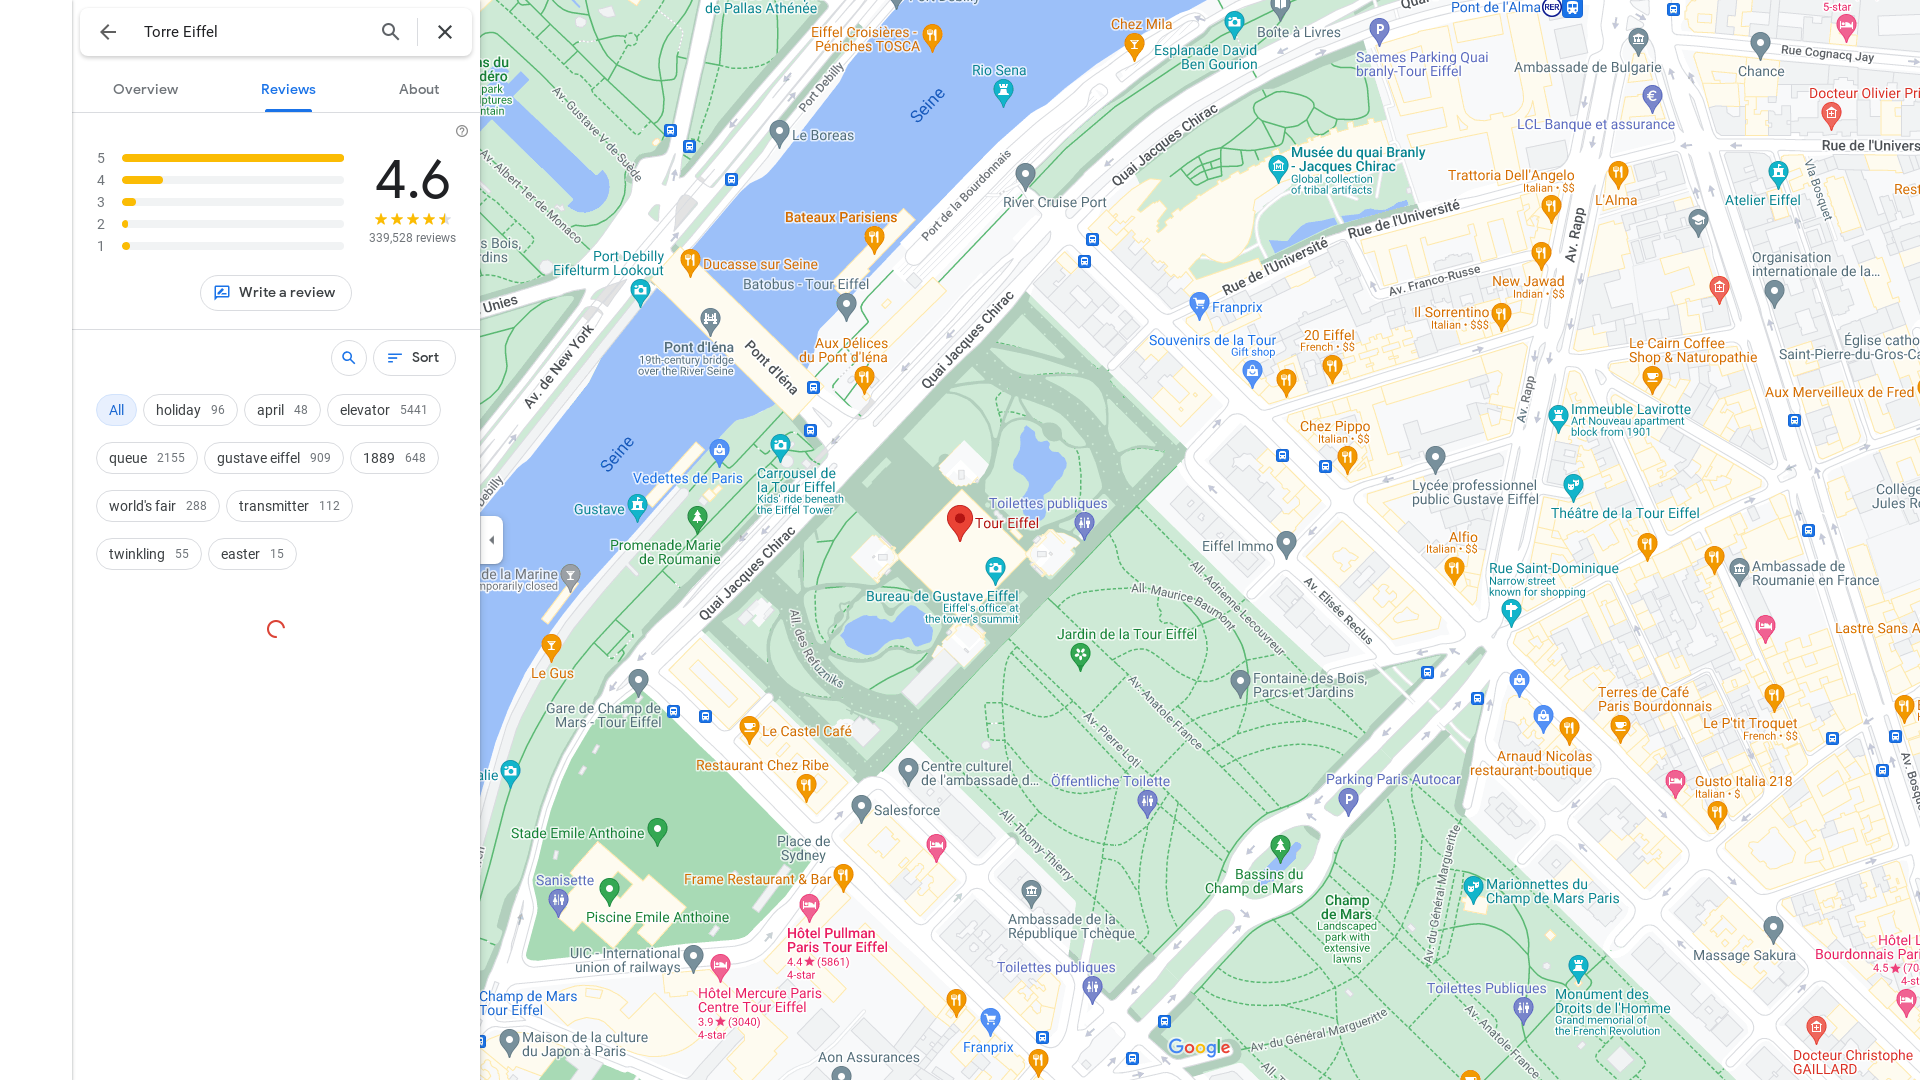

KeyboardInterrupt: ignored

In [ ]:
# kill the chrome process to ensure a fresh start
!pkill chrome

# define the options to run Chrome
# IMPORTANT: these options are quite essential, especially when running it in a remote environment like Google Colab
options = webdriver.ChromeOptions()
# define the size of the window
options.add_argument("--window-size=1920,1080")
# disable notifications to avoid useless interactions 
options.add_argument("--disable-notifications")
# disable the developer options
options.add_argument('--disable-dev-shm-usage')
# set the browser to be headless (i.e., the browser window will be hidden)
options.add_argument('--headless')
# set the browser to run all scripts
options.add_argument('--no-sandbox')

# Selenium (Chrome) driver with the options defined
driver = webdriver.Chrome(options=options)

# input file, containing a list of urls
urls = open('/content/scraping_folder/places_gm.txt')

accept_privacy = True

# iterate over the file and scrape data from each url
for url in urls:

    # get the page
    driver.get(url)
    
    # if the privacy hasn't been accepted
    if(accept_privacy):
        take_screenshot_and_clear(driver)
    
    # wait element
    wait = WebDriverWait(driver, MAX_WAIT)
    
    # accept privacy, if needed
    if(accept_privacy):

        # look for the element containing the accept/reject buttons
        privacy_buttons = driver.find_elements(By.CLASS_NAME, 'lssxud')
        
        # if they are found
        if len(privacy_buttons) > 0:
            # wait for the tag containing the button to be clickable
            wait.until(EC.element_to_be_clickable((By.CLASS_NAME, 'AIC7ge')))

            # click the accept button
            privacy_buttons[1].find_element(By.TAG_NAME, 'button').click()
        
        accept_privacy = False
    
    # wait for the review button to be clickable
    link_review = wait.until(EC.element_to_be_clickable((By.CLASS_NAME, 'RWPxGd'))).find_elements(By.CLASS_NAME, 'hh2c6')[1].click()

    take_screenshot_and_clear(driver)

    # select one of the filters to reduce the amount of elements to sort
    random_filter = # TO BE COMPLETED
    random_filter.click()

    take_screenshot_and_clear(driver)
    
    # send the page extracted with Selenium to BeautifulSoap parser
    response = BeautifulSoup(driver.page_source, 'html.parser')
    
    # count the number of reviews loaded
    n_reviews_loaded = # TO BE COMPLETED
    n_scrolls = 0

    # scroll until scroll limit is reached or number of reviews loaded is enough
    while n_reviews_loaded < N_MAX and n_scrolls < MAX_SCROLLS:
        
        take_screenshot_and_clear(driver)

        # get div container of reviews
        scrollable_div = driver.find_element(By.CLASS_NAME, 'dS8AEf')

        # scroll div to trigger reviews loading
        driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scrollable_div)

        # wait for reviews to load
        time.sleep(5)

        # expand the text of all reviews
        expand_review(driver)

        # count reviews to check if enough
        n_reviews_loaded = # TO BE COMPLETED

        n_scrolls += 1
        
    take_screenshot_and_clear(driver)

    # parse loaded reviews with BeautifulSoup
    response = BeautifulSoup(driver.page_source, 'html.parser')

    # collect all reviews
    reviews = # TO BE COMPLETED

    count = 0

    # for each review
    for idx, review in enumerate(reviews):

        # get review id
        id_review = # TO BE COMPLETED

        # get review date
        # NOTE: date is a string, it needs further processing to become a Date object
        review_date = # TO BE COMPLETED

        # get reviewer information
        # username
        username = # TO BE COMPLETED

        # collect the tag containing the pictures of the review
        reviews_photos = # TO BE COMPLETED

        # if any review is returned
        if reviews_photos != None:
            # retrieve the pictures
            reviews_photos = # TO BE COMPLETED
            n_photos = len(reviews_photos)
        else:
            n_photos = 0

        # number of reviews
        review_tag = # TO BE COMPLETED
        n_reviews = review_tag[len(review_tag) - 2].replace(',','')
        n_reviews = int(n_reviews)

        # get rating of review
        rating_raw = # TO BE COMPLETED
        rating_review = len(rating_raw)

        # get review complete text
        try:
            caption = # TO BE COMPLETED
        except Exception as e:
            # print e
            caption = None

        # build review item
        item = {
            'id_review': id_review,
            'caption': caption,
            'date': review_date,
            'rating': rating_review,
            'username': username,
            'n_review_user': n_reviews,
            'n_photo_user': n_photos,
            'timestamp': date.today()
        }
        
        print(item)
        count += 1

    # save result into MongoDB collection
    print(item)
    
    time.sleep(3)
    clear_output(wait=True)

# close file
urls.close()

# close driver and quit
driver.close()
driver.quit()